In [1]:
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 294 kB 3.7 MB/s eta 0:00:01


# Evaluation Metrics For Classification

## Train the Model

### Load and Prep the data

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
data_path = "data/telecom_churn.csv"
df = pd.read_csv(data_path)

In [4]:
df.columns = df.columns.str.lower().str.replace(" ", "_")
categorical_columns = df.dtypes[df.dtypes == 'object'].index
for col in categorical_columns:
    df[col] = df[col].str.lower().str.replace(" ", "_")

### Clean the data

In [5]:
df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

In [6]:
df['churn'] = (df['churn'] == 'yes').astype(int)

### Split the DataSet

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_full_train = df_full_train.reset_index(drop=True)

In [9]:
y_train = df_train['churn'].values
y_test = df_test['churn'].values
y_val = df_val['churn'].values
y_full_train = df_full_train['churn'].values

In [10]:
del df_train['churn']
del df_test['churn']
del df_val['churn']
del df_full_train['churn']

### Seperate Categorical Variables

In [11]:
numeric_variables = list(df_full_train.dtypes[df_full_train.dtypes != 'object'].index)
numeric_variables.remove('seniorcitizen') # Senior citizen is just a flag

categorical_variables = list(set(df_full_train.dtypes.index) - set(numeric_variables))
categorical_variables.remove('customerid')

### Feature Engineering

In [12]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#### Scale Numeric Variables

In [13]:
X_train_num = df_train[numeric_variables].values

# scaler = StandardScaler()
scaler = MinMaxScaler()

X_train_num = scaler.fit_transform(X_train_num)

#### OHE Categorical Variables

In [14]:
dict_train_cat = df_train[categorical_variables].to_dict(orient='records')
dv = DictVectorizer(sparse=False)

X_train_cat = dv.fit_transform(dict_train_cat)

#### Combine Both

In [15]:
X_train = np.column_stack([X_train_num, X_train_cat])

### Create the Model

In [16]:
model = LogisticRegression(solver='lbfgs', C=1.0, random_state=42, max_iter=500)
model.fit(X_train, y_train)

LogisticRegression(max_iter=500, random_state=42)

### Use the Model

In [17]:
def predict_churn(customers, numeric_variables, categorical_variables, scaler, dv_full, model):
    df_customer = pd.DataFrame(customers)
    X_num = df_customer[numeric_variables].values
    X_num = scaler.transform(X_num)

    dict_cat = df_customer[categorical_variables].to_dict(orient='records')
    X_cat = dv_full.transform(dict_cat)

    X = np.column_stack([X_num, X_cat])
    y_pred = model.predict_proba(X)[:, 1]
    return y_pred

In [18]:
new_customers = df_test.to_dict(orient='records')[:2]

y_pred = predict_churn(
    new_customers,
    numeric_variables,
    categorical_variables,
    scaler,
    dv,
    model
)

(y_pred >= 0.5)

array([False, False])

### Accuracy

In [19]:
val_dict = df_val.to_dict(orient='records')
y_pred = predict_churn(
    val_dict,
    numeric_variables,
    categorical_variables,
    scaler,
    dv,
    model
)
churn_decision = (y_pred >= 0.5)

In [20]:
(y_val == churn_decision).mean()

0.8034066713981547

## Accuracy and Dummy model

### Accuracy

Accuracy tells us about the fraction of correct predictions

In [21]:
print(f"""Total Number of customers: {len(y_val)}
Total number of correct predictions {(y_val == y_pred).sum()}

These numbers are at the thershold of 0.5. Moving the threshold will have an impact of the accuracy""")

Total Number of customers: 1409
Total number of correct predictions 0

These numbers are at the thershold of 0.5. Moving the threshold will have an impact of the accuracy


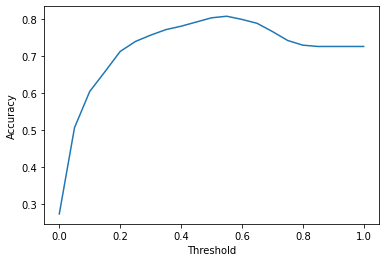

In [22]:
thresholds = np.linspace(0, 1, 21)
accuracies = []
for threshold in thresholds:
    churn_decision = (y_pred >= threshold)
    accuracy = (y_val == churn_decision).mean()
    accuracies.append(accuracy)
sns.lineplot(x=thresholds, y=accuracies)
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.show()

Logistic Regression already optimizes so that 0.5 is the best accuracy score

Sklearn already has a accuracy score

In [23]:
from sklearn.metrics import accuracy_score

In [24]:
accuracy_score(y_val, (y_pred >= 0.5))

0.8034066713981547

### Dummy model

- From the above plot its seems like threshold of 1 has good accuracy
- Which means that prediction that no user will churn gives us good accuracy

In [25]:
from collections import Counter
Counter(y_val)

Counter({0: 1023, 1: 386})

- There is an imbalance in the data set
- There is a lot more non churning users that churning users
- In cases where there is a class imbalance, prediction of majority class will have a good accuracy

## Confusion Table

- CM is a way to evaluate a binary classification model
- CM is a way to organize various mistakes that occur in a binary classification model

In [26]:
conf_table = pd.DataFrame({
    "Predicted Negative": ["True Negative", "False Negative"],
    "Predicted Positive": ["False Positive", "True Positive"],
}, index=["Actual Negative", "Actual Positive"])
conf_table

,Predicted Negative,Predicted Positive
Actual Negative,True Negative,False Positive
Actual Positive,False Negative,True Positive


In [27]:
from sklearn.metrics import confusion_matrix

In [28]:
cm = confusion_matrix(y_val, (y_pred >= 0.5))

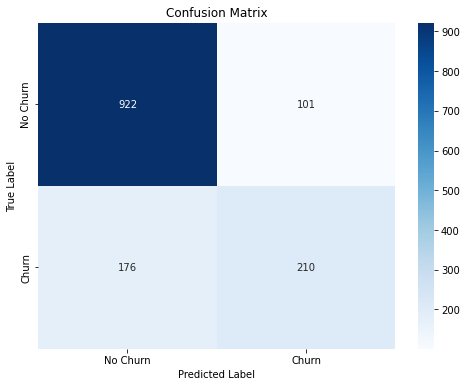

In [29]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=['No Churn', 'Churn'],
           yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [30]:
(cm / cm.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

In [31]:
tn = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tp = cm[1][1]

## Precision And Recall

### Precision

- Precison is a metric that shows the fraction of positive predictions that are correct
- Precision is a metric that shows you, if you get a positive prediciton from the classifier, the probability that its right. 

- $$\text{Precision} = \frac{\text{Correct Positive predictions}}{\text{Total Positive Predictions}}$$

- $$\frac{tp}{tp + fp}$$
- Precision is more important in cases where predicting false positive is costlier

### Recall

- Recall measures the ability 
- Recall is a metric that shows you, if you have a positive instance, the probability that its correctly  labelled by the classifier
- $$ \text{Recall} = \frac{\text{Correctly Identified Positive Instances}}{\text{Total Positive Instances}} $$
- $$\text{Recall} = \frac{tp}{tp + fn} $$
- Recall is more important in cases where missing a positive is costlier (false negative)

## Reciever Operating Characteristics

### False Positive Rate

- Out of all Negative examples, how many were identified as positive
- $$ \text{False Positive Rate} = \frac{\text{Incorrect Positive Predictions}}{\text{Total Negative Examples}}$$
- $$FPR = \frac{FP}{TN + FP} $$

### True Positive Rate

- Out of all the Positive examples, how many were identified as positive
- $$ \text{True Positive Rate} = \frac{\text{Correct Positive Predictions}}{\text{Total Positive Examples}}$$
- $$ \text{TPR} = \frac{\text{TP}}{\text{TP} + \text{FN}}$$
- Same as Recall

### ROC Curves

- Need is to minimize FPR and maximise TPR
- Evaluate FPR and TPR for all thresholds

#### Current Model

In [32]:
# for current threshold
fpr = fp/(fp + tn)
tpr = tp/(tp + fn)
fpr, tpr

(0.09872922776148582, 0.5440414507772021)

In [33]:
def get_scores_df(y_pred, y_val):
    thresholds = np.linspace(0, 1, 101)
    scores = []
    for threshold in thresholds:
        # Calculate the prediction for the current threshold
        churn_decision = (y_pred >= threshold)
        # Accuracy
        accuracy = (y_val == churn_decision).mean()
        # Confusion Matrix
        cm = confusion_matrix(y_val, churn_decision)
        # TPR and FPR
        tn = cm[0][0]
        fp = cm[0][1]
        fn = cm[1][0]
        tp = cm[1][1]
        fpr = fp/(fp + tn)
        tpr = tp/(tp + fn)
        # Scores
        scores.append((threshold, tn, fp, fn, tp, fpr, tpr, accuracy))
    columns = ["threshold", "true_negative", "false_positive", "false_negative", "true_positive", "false_positive_rate", "true_positive_rate", "accuracy"]
    df_scores = pd.DataFrame(scores, columns=columns)
    return df_scores

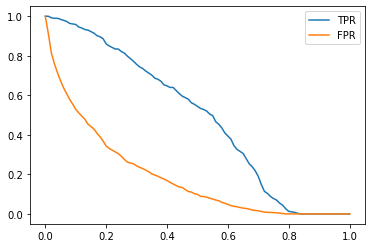

In [34]:
df_scores = get_scores_df(y_pred, y_val)
plt.plot(df_scores.threshold, df_scores.true_positive_rate, label='TPR')
plt.plot(df_scores.threshold, df_scores.false_positive_rate, label='FPR')
plt.legend()
plt.show()

#### Random Model

In [35]:
y_rand = np.random.uniform(0, 1, size=len(y_val))
y_rand

array([0.14783239, 0.89750324, 0.39700965, ..., 0.49496697, 0.24857123,
       0.97526872])

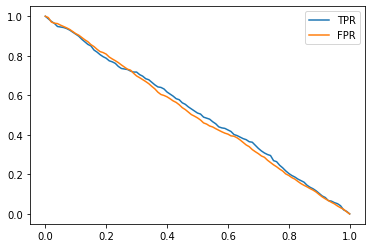

In [36]:
df_scores_rand = get_scores_df(y_rand, y_val)
plt.plot(df_scores_rand.threshold, df_scores_rand.true_positive_rate, label='TPR')
plt.plot(df_scores_rand.threshold, df_scores_rand.false_positive_rate, label='FPR')
plt.legend()
plt.show()

#### Ideal Model

In [62]:
sample_df = df.sample(frac=0.015).sort_values("totalcharges")

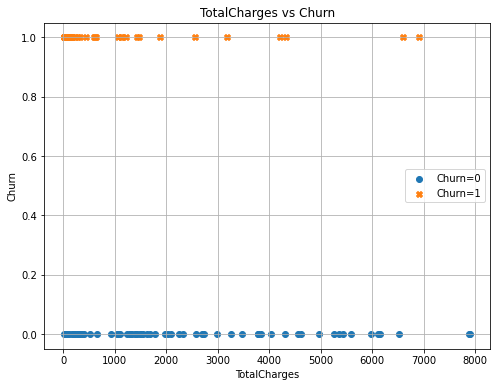

In [63]:
# Creating the plot
plt.figure(figsize=(8, 6))
for churn_value, marker in [(0, 'o'), (1, 'X')]:
    subset = sample_df[sample_df['churn'] == churn_value]
    plt.scatter(subset['totalcharges'], subset['churn'], marker=marker, label=f'Churn={churn_value}')

plt.xlabel('TotalCharges')
plt.ylabel('Churn')
plt.title('TotalCharges vs Churn')
plt.legend()
plt.grid(True)
plt.show()

- In actual cases it is difficult to draw a clear decision boundary
- There will always be misclassification
- So Ideal Model also requires ideal dataset of customers sorted by churn probability
- Ideal model then is the one that will give no errors when the threshold is set at the average churn rate of the dataset

In [51]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(1023, 386)

In [54]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal # Ideal dataset

array([0, 0, 0, ..., 1, 1, 1])

In [57]:
y_ideal_pred = np.linspace(0, 1, len(y_val)) # Ideal model

In [58]:
((y_ideal_pred >= 0.726) == y_ideal).mean() # For threshold == average churn rate, it gives 100% accuracy

1.0

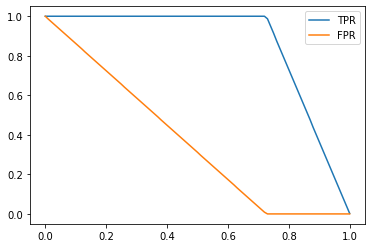

In [59]:
df_scores_ideal = get_scores_df(y_ideal_pred, y_ideal)
plt.plot(df_scores_ideal.threshold, df_scores_idealdf_scores_ideal.true_positive_rate, label='TPR')
plt.plot(df_scores_ideal.threshold, df_scores_ideal.false_positive_rate, label='FPR')
plt.legend()
plt.show()

##### TPR Change Explained


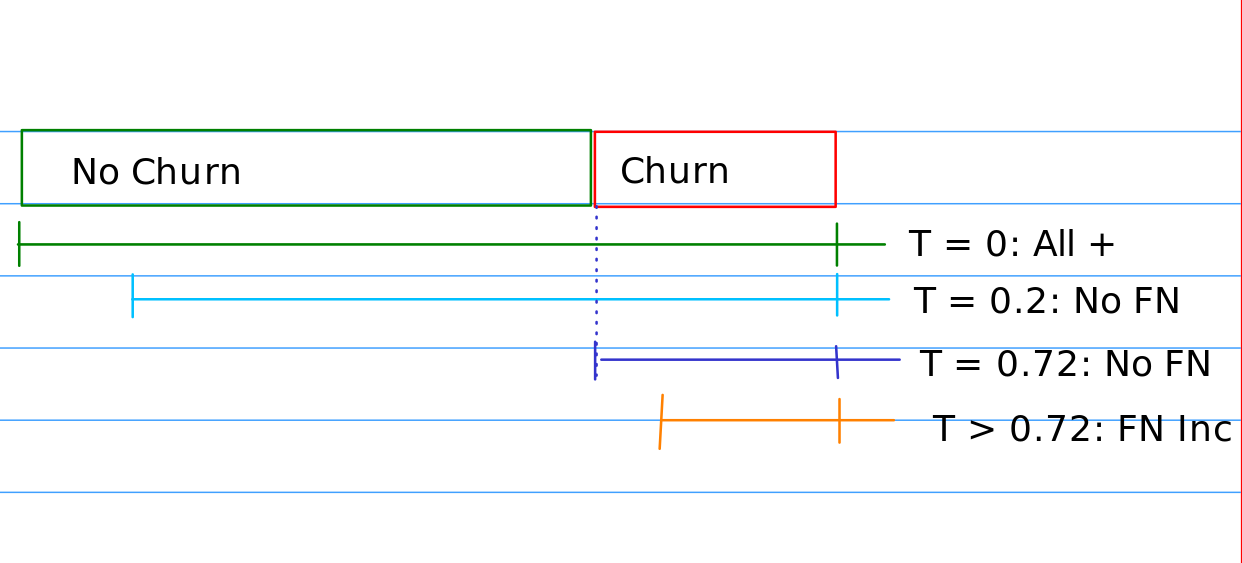

- When the Threshold is 0 the TP is not affected as all churning customers are marked as churning 
- When threshhold is greater than 0.72, then only do we get false negative, So TPR reduces
- At Threshold = 1 all are marked as non churning, so -ve all are false negative
- Reverse is true for FPR

#### All Models

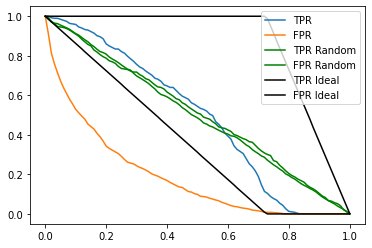

In [66]:
plt.plot(df_scores.threshold, df_scores.true_positive_rate, label='TPR')
plt.plot(df_scores.threshold, df_scores.false_positive_rate, label='FPR')
plt.plot(df_scores_rand.threshold, df_scores_rand.true_positive_rate, label='TPR Random', color='green')
plt.plot(df_scores_rand.threshold, df_scores_rand.false_positive_rate, label='FPR Random', color='green')
plt.plot(df_scores_ideal.threshold, df_scores_ideal.true_positive_rate, label='TPR Ideal', color='black')
plt.plot(df_scores_ideal.threshold, df_scores_ideal.false_positive_rate, label='FPR Ideal', color='black')
plt.legend()
plt.show()

#### ROC Curve

- FPR vs TPR curve with reference models
- Model should be as close as possible to the ideal one
- FPR = TPR = 0 => Very high threshold
- FPR = TPR = 1 => Very low threshold

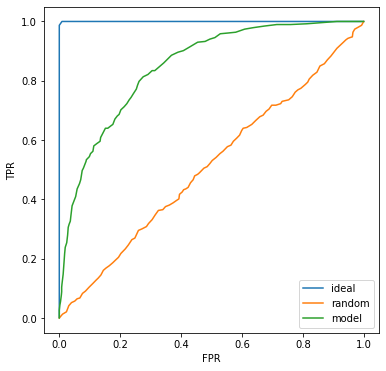

In [74]:
plt.figure(figsize=(6,6))
plt.axes(xlabel="FPR", ylabel="TPR")
plt.plot(df_scores_ideal.false_positive_rate, df_scores_ideal.true_positive_rate, label="ideal")
plt.plot(df_scores_rand.false_positive_rate, df_scores_rand.true_positive_rate, label="random")
plt.plot(df_scores.false_positive_rate, df_scores.true_positive_rate, label="model")
plt.legend()